# Custom regression model

### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from own_functions import custom_dropper, model_classification

### Settings

In [2]:
# Pandas configuration
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 400

# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

### Loading and preparing the data

In [3]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [4]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

## The seasonality model

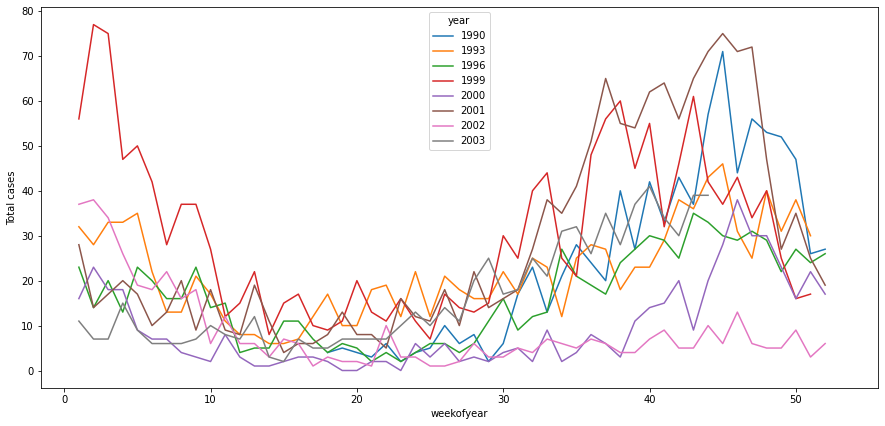

In [5]:
(
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
    # Exclude the years with epidemics using a threshold
    .loc[:,lambda df: df.max(axis=0) < 100]
    .plot(ylabel='Total cases')
);

In [6]:
def get_smooth_seasonality_df(df, colnames, threshold=1000):
    '''
    Retrieve mean total cases for each week of the year, excluding those 
    years that exceed a threshold (years with epidemics).
    --------------------
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    threshold: number of total cases above which the years should be excluded.
    --------------------
    Output:
    Pandas dataframe with mean total cases for each week of the year
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < threshold]
            .mean(axis=1)
        )
        
        # Add weeks before and after, so that after 
        # centered smoothing there are no missing values
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [7]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', threshold=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


## Evaluating the saisonality as a baseline model

In [8]:
def seasonality_baseline_eval(df, seas):
    '''
    Plots the actual case numbers along with the predictions provided by the seasonality.
    It also outputs evaluation metrics for the predictions.
    -----------------
    In:
    df: data frame with the total case numbers
    seas: seasonality model (data frame with mean case numbers for each week of the year)
    -----------------
    Out: plot and printed metrics
    '''
    eval_df = (
        df
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 27.5
--------------------
MAE: 18.12
Explained variance: 0.076
--------------------


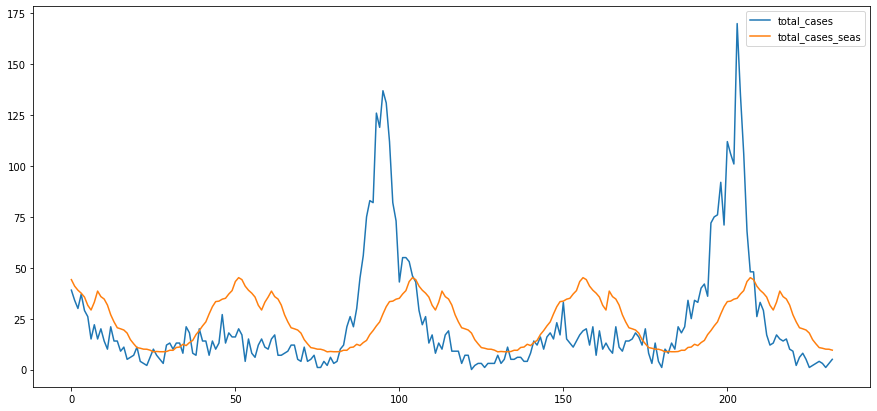

In [9]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

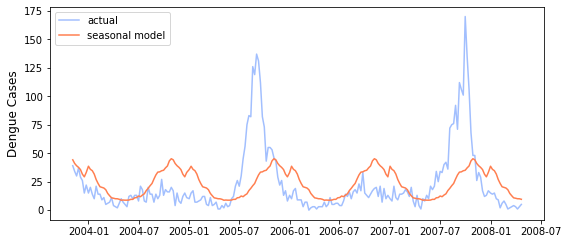

In [10]:
# Plot for the presentation
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

plot_df = (
    sj_train_test
    .loc[:,['weekofyear', 'total_cases']]
    .merge(sj_train_train_seas,
           how='left',
           on='weekofyear',
           suffixes=('','_seas')
          )
    .iloc[:,1:]
)
plot_df.index = sj_train_test.index
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(plot_df.index, plot_df.total_cases, color=colors['actual_weekly'])
plt.plot(plot_df.index, plot_df.total_cases_seas, color=colors['predicted_weekly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'seasonal model'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/SJ_train_test_seasonal_model.png', dpi=200)

# Poisson Regression

## Substracting the saisonality

In [11]:
def substract_seas(df, cols, seas, drop=False):
    '''
    Substracts the seasonality from the actual values and adds new column(s) with this information to the data frame.
    -----------------
    In: 
    df: data frame with total cases and features if desired.
    cols: column or columns for which to transform the data
    seas: seasonality model (data frame with mean case numbers for each week of the year)
    drop: whether to drop the seasonality model from the outputted data frame
    -----------------
    Out: dataframe with additional columns
    
    '''
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [12]:
sj_train_train = substract_seas(sj_train_train, 'total_cases', sj_train_train_seas)
sj_train_test = substract_seas(sj_train_test, 'total_cases', sj_train_train_seas)

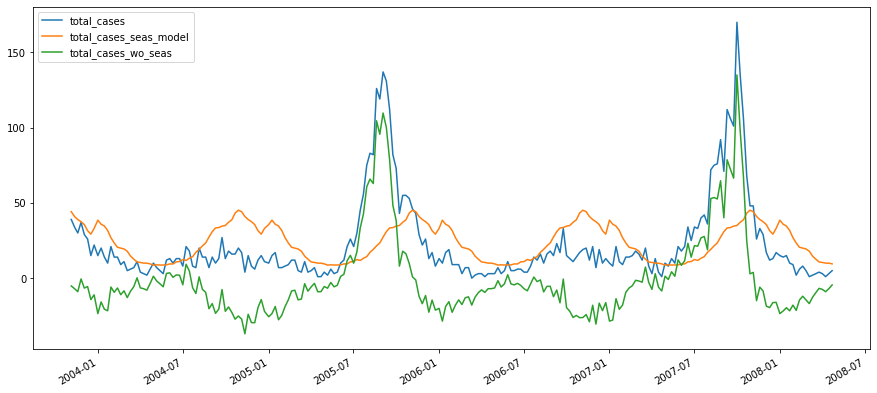

In [13]:
(
    sj_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

## Part 1: San Juan Validation

### Feature selection

In [14]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', threshold=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


In [15]:
def get_env_features(df):
    '''
    Retrieve a list of column names that refer to columns that contain variables that can be used to train a model.
    -------------------------
    In: data frame
    -------------------------
    Out: list of column names
    '''
    return (
        df.drop([
          'total_cases',
           'week_start_date',
           'city',
           'year',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )

In [16]:
env_features = get_env_features(sj_train_train)

In [17]:
def reduce_features_lda_threshold(df, df_train, cols, target, threshold=100):
    '''
    Performs a Linear Discriminant Analysis (LDA) on the selected features with respect to 
    a classification of datapoints into regular and epidemic points using a threshold.
    The LDA is fit on the training data (!) and the test/validation data is subsequently transformed, 
    ensuring no data leakage.
    --------------------
    In:
    df: data frame with features
    df_train: data frame with training data (can be the same as df)
    cols: the feature columns that should be used for this transformation
    target: name of the target variable
    threshold: number of cases above which an epidemic is assumed (used for the LDA)
    --------------------
    Out: dataframe with one column representing the (predicted) deviations from the seasonality
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > threshold, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [18]:
def add_dev_from_seas(df, df_train, cols, threshold):
    '''
    Applies the reduce_features_lda_treshold function and adds its output to the data frame.
    --------------------
    In:
    df: data frame with features
    df_train: data frame with training data (can be the same as df)
    cols: the feature columns that should be used for this transformation
    threshold: number of cases above which an epidemic is assumed (used for the LDA)
    --------------------
    Out: input dataframe with additional column representing the (predicted) deviance from the seasonality
    '''
    deviation = reduce_features_lda_threshold(df, df_train, cols, 'total_cases_wo_seas', threshold)
    deviation.columns = ['deviation']
    return df.join(deviation, rsuffix='xxx')

In [19]:
sj_train_train = add_dev_from_seas(sj_train_train, sj_train_train, env_features, 150)
sj_train_test = add_dev_from_seas(sj_train_test, sj_train_train, env_features, 150)

In [20]:
def get_highest_corr_features(df, n):
    corr_mat = df.corr()
    return (
        corr_mat['total_cases']
        .drop([
            'total_cases',
            'year',
            'total_cases_wo_seas',
            'weekofyear'])
        .abs()
        .sort_values()
        .tail(n)
        .index
    )
my_features = get_highest_corr_features(sj_train_train, 50)

In [21]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [22]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [23]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [25]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [26]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [27]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [28]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Smoothing

In [29]:
def lossless_centered_smoothing(test_pred, train_y, w=3, train=False):
    '''
    Applies a centered rolling mean smoothing to the predictions, 
    while avoiding to generate missing values at the begiiing and the end.
    This is done by including data from the training set and using a non-centered
    smoothing (only) for the last data points.
    -----------------------
    In:
    test_pred: pandas Series of interest
    train_y: training set to fill the first values of test_pred
    w: window size for smoothing
    test: whether the function is used for validation/test data or for the 
    train data (for which there are no values to fill-in from another data frame)
    ------------------------
    Out: smoothened Pandas Series with the same length as the input
    '''
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[-int((w-1) / 2):] = tail
        if train == False:
            smoothed[:int((w-1) / 2)] = trunk

    return smoothed

### Evaluation

In [30]:
def evaluate_pred_val(y, y_pred, y_train, w, train=False):
    '''
    Get a quick plot of the model and its smoothed version plus evaluation metrics of both. 
    Only for the validation part (when there are actual known values of the taget variable).
    ------------------
    In:
    y: the actual values of the target
    y_pred: the predictions of the model
    y_train: training data (only to fill missing values while smoothing)
    w: window size for smoothing
    test: whether the function is used for validation data or for the 
    train data (for which there are no values to fill-in from another data frame)
    ------------------
    Out: only plots and printed lines
    '''
    y.plot()
    y_pred.plot()
    lossless_centered_smoothing(y_pred, y_train, w=w, train=train).plot();
    print('Raw:')
    model_classification(y, y_pred)
    print('\nWith smoothing:')
    model_classification(y.iloc[int((w-1)/2):], lossless_centered_smoothing(y_pred, y_train, w=w, train=True).dropna())

Raw:
--------------------
RMSE: 3.49
--------------------
MAE: 2.72
Explained variance: 0.996
--------------------

With smoothing:
--------------------
RMSE: 13.1
--------------------
MAE: 7.43
Explained variance: 0.947
--------------------


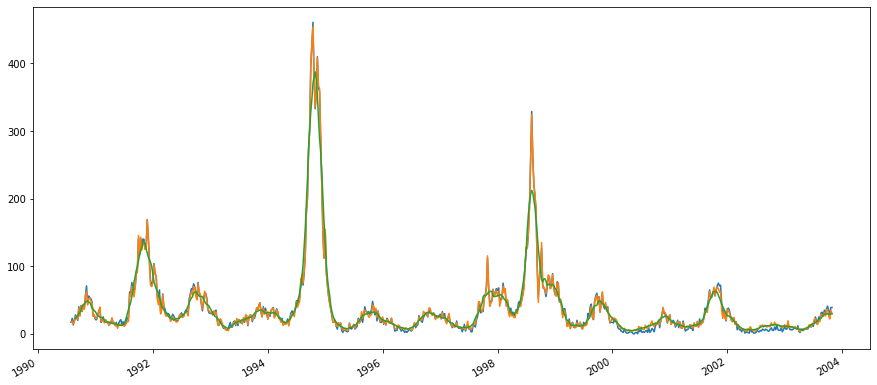

In [31]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 19.56
--------------------
MAE: 12.88
Explained variance: 0.586
--------------------

With smoothing:
--------------------
RMSE: 15.59
--------------------
MAE: 11.34
Explained variance: 0.767
--------------------


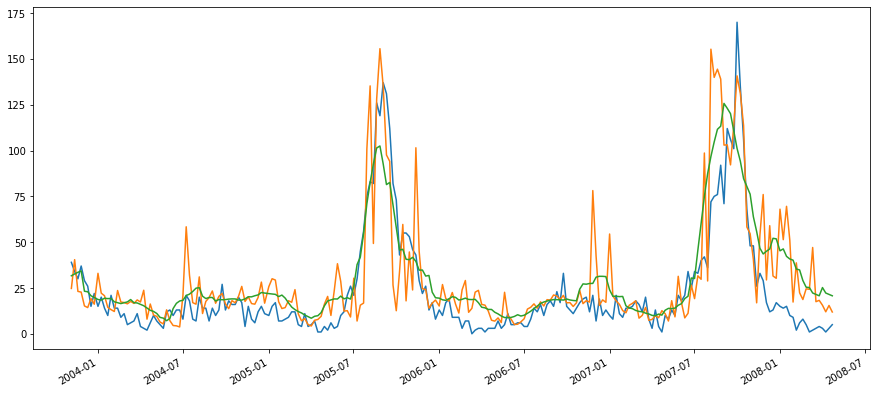

In [32]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

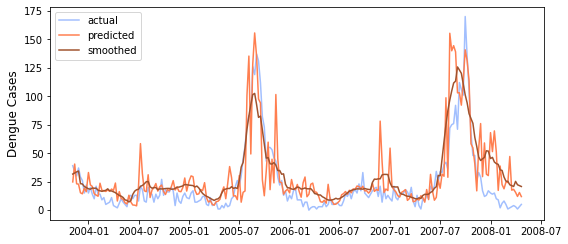

In [33]:
# Plot for the presentation
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(y_test.index, y_test, color=colors['actual_weekly'])
plt.plot(y_test.index, y_test_pred, color=colors['predicted_weekly'])
plt.plot(y_test.index, lossless_centered_smoothing(y_test_pred, y_train, w=9), color=colors['predicted_monthly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted', 'smoothed'])
fig.tight_layout()
fig.savefig('plots/SJ_seasonal_poisson_regression_train_test.png', dpi=200)

## Part 2: San Juan Test Data

### Feature selection

In [34]:
sj_train_seas = get_smooth_seasonality_df(sj_train, 'total_cases', threshold=150)
sj_train_seas.head()

,weekofyear,total_cases
0,1,30.564103
1,2,29.358974
2,3,28.051282
3,4,25.461538
4,5,21.615385


In [35]:
sj_train = substract_seas(sj_train, 'total_cases', sj_train_seas)

In [36]:
sj_train.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,...,cum_precip_6w_lag1,cum_precip_6w_lag2,cum_precip_6w_lag3,cum_precip_6w_lag4,cum_precip_6w_lag5,cum_precip_6w_lag6,cum_precip_6w_lag7,cum_precip_6w_lag8,total_cases_seas_model,total_cases_wo_seas
1990-04-30,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.820513,-3.820513
1990-05-07,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.051282,-3.051282
1990-05-14,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.923077,-3.923077
1990-05-21,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.205128,-5.205128
1990-05-28,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.717949,-2.717949


In [37]:
sj_train_seas.head()

,weekofyear,total_cases
0,1,30.564103
1,2,29.358974
2,3,28.051282
3,4,25.461538
4,5,21.615385


In [38]:
def add_seas_model(df, seas):
    '''
    Adds the predictions of the seasonality model to the data frame.
    This can be seen as a simplified version of substract_seas_model that also works for the test part of the data.
    --------------------
    In: 
    df: data frame with total cases and features if desired.
    seas: seasonality model (data frame with mean case numbers for each week of the year)
    -----------------
    Out: input dataframe with additional column
    '''
    df_index = df.index
    seas_model = seas.rename(columns={'total_cases': 'total_cases_seas_model'})
    df = df.merge(seas_model, how='left', on='weekofyear')
    df.index = df_index
    return df

In [39]:
sj_test = add_seas_model(sj_test, sj_train_seas)

In [45]:
def get_env_features_test(df):
    '''
    Retrieve a list of column names that refer to columns that contain variables that can be used to train a model.
    Specialised for the test data
    -------------------------
    In: data frame
    -------------------------
    Out: list of column names
    '''
    return (
        df.drop([
           'week_start_date',
           'city',
           'year',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )

In [46]:
env_features = get_env_features_test(sj_test)
# env_features

In [47]:
sj_train = add_dev_from_seas(sj_train, sj_train, env_features, 150)
sj_test = add_dev_from_seas(sj_test, sj_train, env_features, 150)

In [48]:
my_features = list( get_highest_corr_features(sj_train, 50) )

In [49]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [50]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [52]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [53]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [54]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [55]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = sj_test.index

### Evaluation

Raw:
--------------------
RMSE: 4.56
--------------------
MAE: 3.35
Explained variance: 0.992
--------------------

With smoothing:
--------------------
RMSE: 12.43
--------------------
MAE: 7.11
Explained variance: 0.942
--------------------


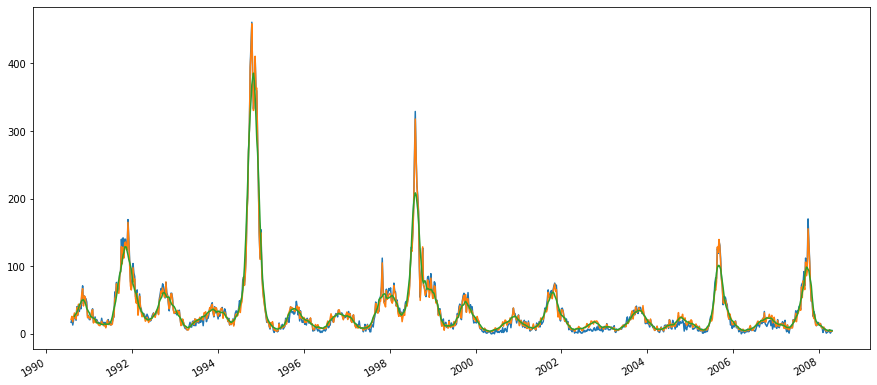

In [59]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

In [60]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

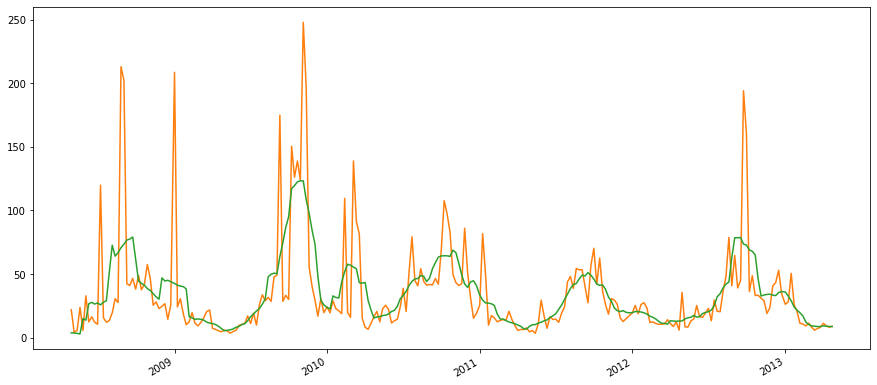

In [61]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [62]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=5)

## Part 3: Iquitos Validation

### Feature selection

In [63]:
iq_train_train_seas = get_smooth_seasonality_df(iq_train_train, 'total_cases', threshold=60)
iq_train_train_seas.head()

,weekofyear,total_cases
0,1,13.666667
1,2,14.666667
2,3,16.333333
3,4,15.555556
4,5,16.888889


In [64]:
iq_train_train = substract_seas(iq_train_train, 'total_cases', iq_train_train_seas)
iq_train_test = substract_seas(iq_train_test, 'total_cases', iq_train_train_seas)

In [65]:
env_features = get_env_features(iq_train_train)

In [66]:
iq_train_train = add_dev_from_seas(iq_train_train, iq_train_train, env_features, 60)
iq_train_test = add_dev_from_seas(iq_train_test, iq_train_train, env_features, 60)

In [67]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [68]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [69]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [71]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [72]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [73]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [74]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.38
--------------------
MAE: 1.1
Explained variance: 0.985
--------------------

With smoothing:
--------------------
RMSE: 7.03
--------------------
MAE: 3.56
Explained variance: 0.617
--------------------


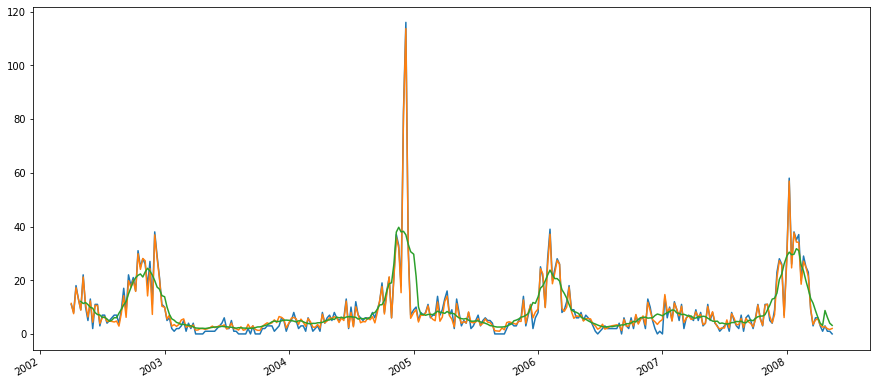

In [77]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 13.17
--------------------
MAE: 9.26
Explained variance: -0.104
--------------------

With smoothing:
--------------------
RMSE: 11.69
--------------------
MAE: 8.92
Explained variance: 0.198
--------------------


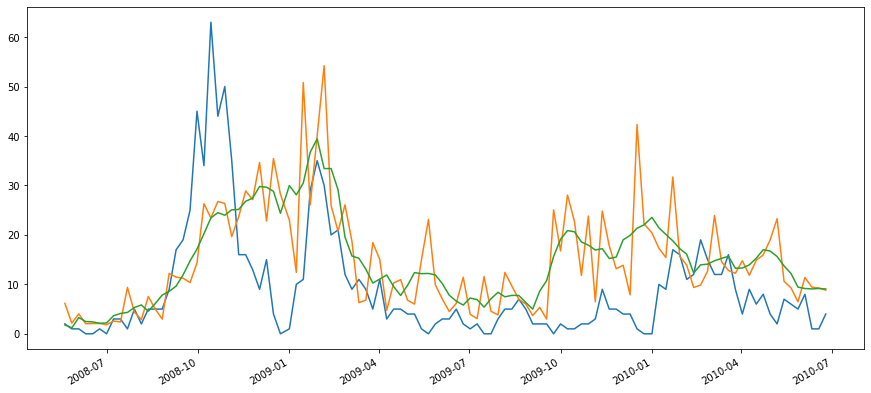

In [78]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=5)

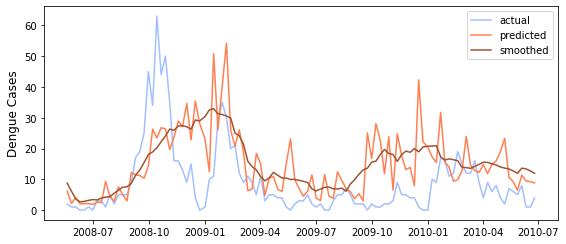

In [80]:
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(y_test.index, y_test, color=colors['actual_weekly'])
plt.plot(y_test.index, y_test_pred, color=colors['predicted_weekly'])
plt.plot(y_test.index, lossless_centered_smoothing(y_test_pred, y_train, w=9), color=colors['predicted_monthly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted', 'smoothed'])
fig.tight_layout()
fig.savefig('plots/IQ_seasonal_poisson_regression_train_test.png', dpi=200)

## Part 3: Iquitos Test Data

### Feature selection

In [81]:
iq_train_seas = get_smooth_seasonality_df(iq_train, 'total_cases', threshold=150)
iq_train_seas.head()

,weekofyear,total_cases
0,1,10.055556
1,2,12.555556
2,3,14.962963
3,4,15.333333
4,5,16.555556


In [82]:
iq_train = substract_seas(iq_train, 'total_cases', iq_train_seas)

In [83]:
iq_test = add_seas_model(iq_test, iq_train_seas)

In [88]:
env_features = get_env_features_test(iq_test)

In [89]:
iq_train = add_dev_from_seas(iq_train, iq_train, env_features, 60)
iq_test = add_dev_from_seas(iq_test, iq_train, env_features, 60)

In [90]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [91]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [92]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [93]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [94]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [95]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [96]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [97]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = iq_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.2
--------------------
MAE: 0.91
Explained variance: 0.989
--------------------

With smoothing:
--------------------
RMSE: 6.57
--------------------
MAE: 3.43
Explained variance: 0.664
--------------------


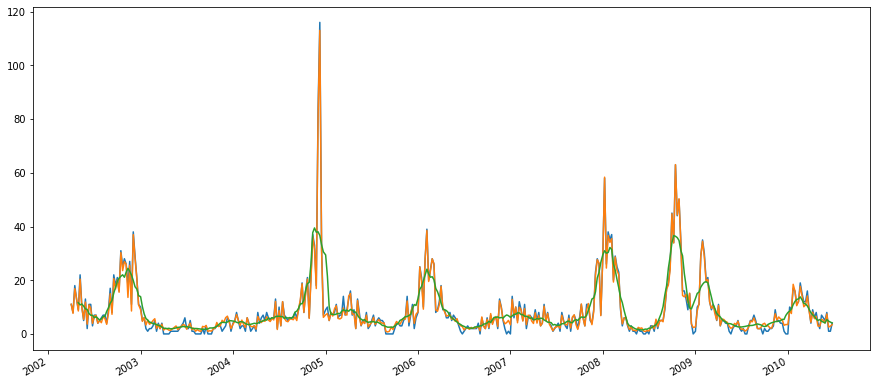

In [100]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

In [101]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

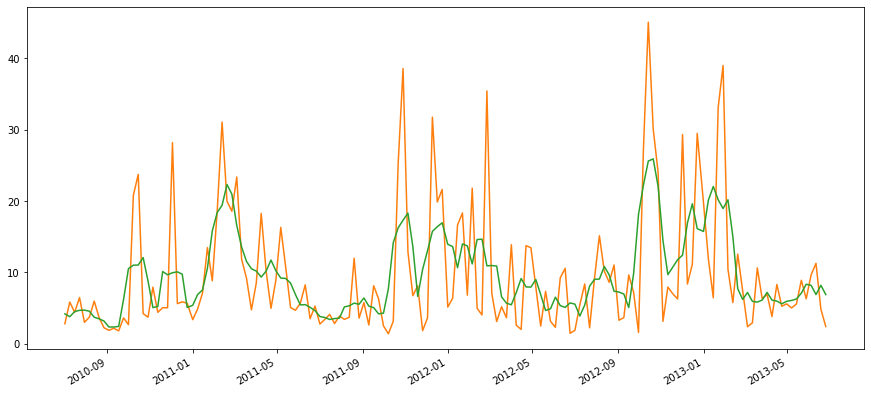

In [102]:
evaluate_pred_test(y_test_pred, y_train, w=5)

In [103]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=5)

## Submission

In [105]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    '''
    Building a submission file from th epredictions for uploading it to DrivenData.
    ------------------
    In:
    pred_1: predictions for San Juan (pandas series)
    test_df_1: test data frame for San Juan (for the metadata that is not directly in the index of the prediction)
    pred_2: predictions for Iquitos (pandas series)
    test_df_2: test data frame for Iquitos (for the metadata that is not directly in the index of the prediction)
    -------------------
    Out: the submission as a dataframe (for inspection prior to submission)
    '''
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    subm_table.total_cases = subm_table.total_cases.astype(int)
    return subm_table

In [107]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df

,city,year,weekofyear,total_cases
0,sj,2008,18,2
1,sj,2008,19,3
2,sj,2008,20,12
3,sj,2008,21,14
4,sj,2008,22,16
...,...,...,...,...
151,iq,2013,22,8
152,iq,2013,23,8
153,iq,2013,24,6
154,iq,2013,25,8


In [108]:
submission_df.to_csv('data/submission_poisson_gradient_boosting_50_feats_plus_lda.csv', index=False)